<a href="https://colab.research.google.com/github/EnjoyCpp/ELF-2-task-/blob/main/ND2_U%C5%BEduotis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotekų importavimas

In [ ]:
!pip install tqdm

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.cluster import KMeans
import sys
import shutil
from tqdm import tqdm

# Apsirašome pagalbines funkcijas
Pirma apsirašome funkcija, kuri sukurtu katalogus, kuriuos naudosime kadrų saugojimui.

In [ ]:
def create_output_folder(output_folder):
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    os.makedirs(output_folder)

Apsirašome funkcijas, kurios analizuoja kadrų suliejimo lygį ir judėjimo lygį.

In [2]:
def analyze_frame_quality(frame, prev_frame):
    blur_score = cv2.Laplacian(frame, cv2.CV_64F).var()
    motion_score = 0

    if prev_frame is not None:
        diff = cv2.absdiff(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY),
                           cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY))
        motion_score = np.mean(diff)

    return blur_score, motion_score

In [3]:
"""
Ši funkcija identifikuoja blogiausius kadrus pagal suliejimo ir judesio rodiklius,
pažymi juos tekstu „BAD FRAME“ ir išsaugo nurodytame aplanke.
"""
def highlight_bad_frames(frame_filenames, quality_scores, bad_frames_folder, result_file):
    create_output_folder(bad_frames_folder)

    blur_threshold = np.percentile([s[0] for s in quality_scores], 90)
    motion_threshold = np.percentile([s[1] for s in quality_scores], 90)

    worst_indices = [
        idx for idx, score in enumerate(quality_scores)
        if score[0] > blur_threshold or score[1] > motion_threshold
    ]

    with open(result_file, 'w') as file:
        file.write("Frame ID, Blur Score, Motion Score\n")

        for i, idx in enumerate(worst_indices):
            frame = cv2.imread(frame_filenames[idx])
            if frame is not None:
                cv2.putText(frame, "BAD FRAME", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                marked_path = os.path.join(bad_frames_folder, f'marked_frame_{idx:04d}.jpg')
                cv2.imwrite(marked_path, frame)

                blur_score, motion_score = quality_scores[idx]
                file.write(f"{idx}, {blur_score:.2f}, {motion_score:.2f}\n")

                sys.stdout.write(f"\rMarking bad frames: {i+1}/{len(worst_indices)}")
                sys.stdout.flush()

    print("\nBad frames marked and results saved.")

In [ ]:
"""
Ši funkcija atlieka kadrų klasterizaciją pagal suliejimo ir judesio rodiklius,
suskirsto juos į pasirinktą klasterių skaičių ir išsaugo atitinkamuose aplankuose.
"""
def cluster_frames(quality_scores, frame_filenames, output_folder, num_clusters=3):
    quality_scores = np.array(quality_scores)

    if len(quality_scores) < num_clusters:
        print("Not enough frames to perform clustering.")
        return

    # Performing KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(quality_scores)

    cluster_output_folder = os.path.join(output_folder, "clusters")
    create_output_folder(cluster_output_folder)

    # Create output folders for each cluster
    for i in range(num_clusters):
        cluster_folder = os.path.join(cluster_output_folder, f"cluster_{i}")
        create_output_folder(cluster_folder)

    # Progress bar for saving clustered frames
    print("Saving clustered frames...")
    for idx, cluster in tqdm(enumerate(clusters), total=len(clusters), desc="Saving frames"):
        frame_path = frame_filenames[idx]
        cluster_folder = os.path.join(cluster_output_folder, f"cluster_{cluster}")
        frame_name = os.path.basename(frame_path)

        # Read the frame and save it in the respective cluster folder
        frame = cv2.imread(frame_path)
        if frame is not None:
            cv2.imwrite(os.path.join(cluster_folder, frame_name), frame)

    # Visualizing clusters
    visualize_clusters(quality_scores, clusters)

def visualize_clusters(quality_scores, clusters):
    print("Visualizing clusters...")

    quality_scores = np.array(quality_scores)
    plt.scatter(quality_scores[:, 0], quality_scores[:, 1], c=clusters, cmap='viridis', marker='o')
    plt.xlabel("Blur Score")
    plt.ylabel("Motion Score")
    plt.title("Frame Clustering")
    plt.colorbar(label="Cluster")
    plt.show()

In [5]:
"""
Ši funkcija išskiria kadrus iš vaizdo įrašų, įvertina jų kokybę pagal suliejimo ir judesio rodiklius,
saugo juos atitinkamuose aplankuose ir taiko klasterizaciją bei blogų kadrų identifikavimą.
"""
def extract_frames(video_paths, output_root):
    for video_path in video_paths:
        print(f"Attempting to open video: {video_path}")  # Debugging line
        video_name = os.path.splitext(os.path.basename(video_path))[0]
        output_folder = os.path.join(output_root, video_name, "frames")
        bad_frames_folder = os.path.join(output_root, video_name, "bad_frames")
        result_file = os.path.join(output_root, video_name, "results.txt")

        create_output_folder(output_folder)
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"Failed to open video: {video_path}")
            continue

        frame_count = 0
        prev_frame = None
        quality_scores = []
        frame_filenames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame_filename = os.path.join(output_folder, f'frame_{frame_count:04d}.jpg')
            cv2.imwrite(frame_filename, frame)
            frame_filenames.append(frame_filename)

            blur_score, motion_score = analyze_frame_quality(frame, prev_frame)
            quality_scores.append([blur_score, motion_score])

            sys.stdout.write(f"\rProcessing {video_name}: Frame {frame_count}/{total_frames} - Blur: {blur_score:.2f}, Motion: {motion_score:.2f}")
            sys.stdout.flush()

            prev_frame = frame.copy()
            frame_count += 1

        cap.release()
        print(f"\nCompleted {video_name}. Extracted {frame_count} frames.")

        highlight_bad_frames(frame_filenames, quality_scores, bad_frames_folder, result_file)
        cluster_frames(quality_scores, frame_filenames, output_folder)

In [ ]:
# Įkeliame vaizdo įrašą
uploaded = files.upload()

Saving 481827951_8814865931946884_2986580272030493119_n (1).mp4 to 481827951_8814865931946884_2986580272030493119_n (1).mp4
Saving 5538137-hd_1920_1080_25fps (3).mp4 to 5538137-hd_1920_1080_25fps (3).mp4


['481827951_8814865931946884_2986580272030493119_n (1).mp4', '5538137-hd_1920_1080_25fps (3).mp4']
Attempting to open video: 481827951_8814865931946884_2986580272030493119_n (1).mp4
Processing 481827951_8814865931946884_2986580272030493119_n (1): Frame 462/463 - Blur: 194.60, Motion: 8.45
Completed 481827951_8814865931946884_2986580272030493119_n (1). Extracted 463 frames.
Marking bad frames: 94/94
Bad frames marked and results saved.
Saving clustered frames...


Saving frames: 100%|██████████| 463/463 [00:05<00:00, 83.79it/s]


Visualizing clusters...


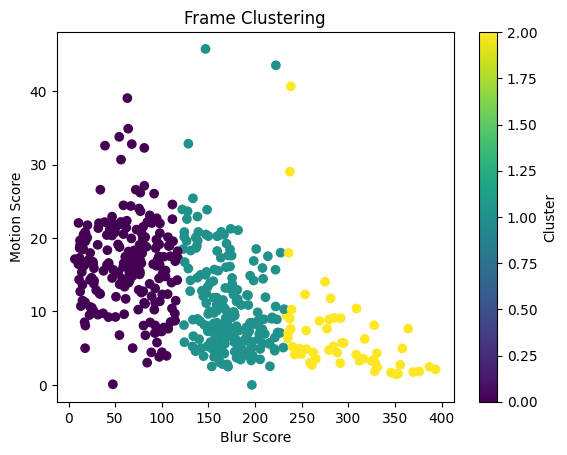

Attempting to open video: 5538137-hd_1920_1080_25fps (3).mp4
Processing 5538137-hd_1920_1080_25fps (3): Frame 474/475 - Blur: 69.29, Motion: 7.32
Completed 5538137-hd_1920_1080_25fps (3). Extracted 475 frames.
Marking bad frames: 80/80
Bad frames marked and results saved.
Saving clustered frames...


Saving frames: 100%|██████████| 475/475 [00:13<00:00, 34.69it/s]


Visualizing clusters...


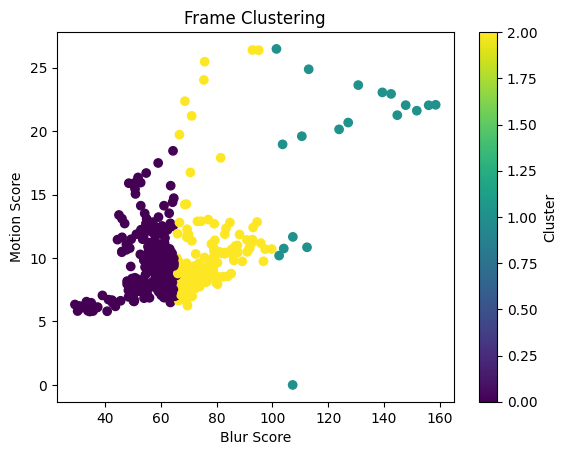

In [ ]:
video_path = list(uploaded.keys())  # Paimame įkelto failo pavadinimą
output_folder = "frames"  # Pakeiskite į norimą išvesties aplanką

extract_frames(video_path, output_folder)